# MNIST 실습
## 가상 환경
python = 3.12.8  
numpy==2.0.2  
matplotlib==3.10.0  
tqdm==4.67.1
torch==2.6.0
torchvision==0.21.0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
import random
import platform
import warnings

import gzip
from urllib.request import urlretrieve

In [2]:
# 재현성을 위한 시드 고정
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED) # Python 환경변수인 PYTHONHASHSEED를 설정하는 코드

In [3]:
# 현재 OS 및 파이썬 버전 확인
current_os = platform.system()
print(f"Current OS: {current_os}")
print(f"Python Version: {platform.python_version()}")

# 라이브러리 버전 확인
from importlib.metadata import version
print("numpy version : {}".format(version("numpy")))
print("matplotlib version : {}".format(version("matplotlib")))

Current OS: Windows
Python Version: 3.12.8
numpy version : 2.0.2
matplotlib version : 3.10.0


In [4]:
# matplotlib의 해상도 높이기
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# dataset 불러오기
import torch
import torchvision.datasets as datasets
import torchvision.transforms as trans

train_data = datasets.MNIST('./data',train=True,download=True)
test_data = datasets.MNIST('./data',train=False,download=True)

In [6]:
# 이미지 데이터를 NumPy 배열로 변환
x_train = train_data.data.numpy()
y_train = train_data.targets.numpy()

x_test = test_data.data.numpy()
y_test = test_data.targets.numpy()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [7]:
def _onehot(integer_labels):
    n_rows = len(integer_labels) # label data의 길이
    n_cols = integer_labels.max() + 1 # label data의 최댓값(9) +1
    
    # 0으로 채워진 (n_rows,n_cols) 크기의 행렬 생성 ex.(60000,10)
    onehot = np.zeros((n_rows,n_cols),dtype='uint8')
    # onehot 행렬의 각 행에 해당하는 라벨을 1로 변경
    onehot[np.arange(n_rows), integer_labels] = 1 
    
    return onehot

In [8]:
y_train = _onehot(y_train)
y_test = _onehot(y_test)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000, 10) (10000, 28, 28) (10000, 10)


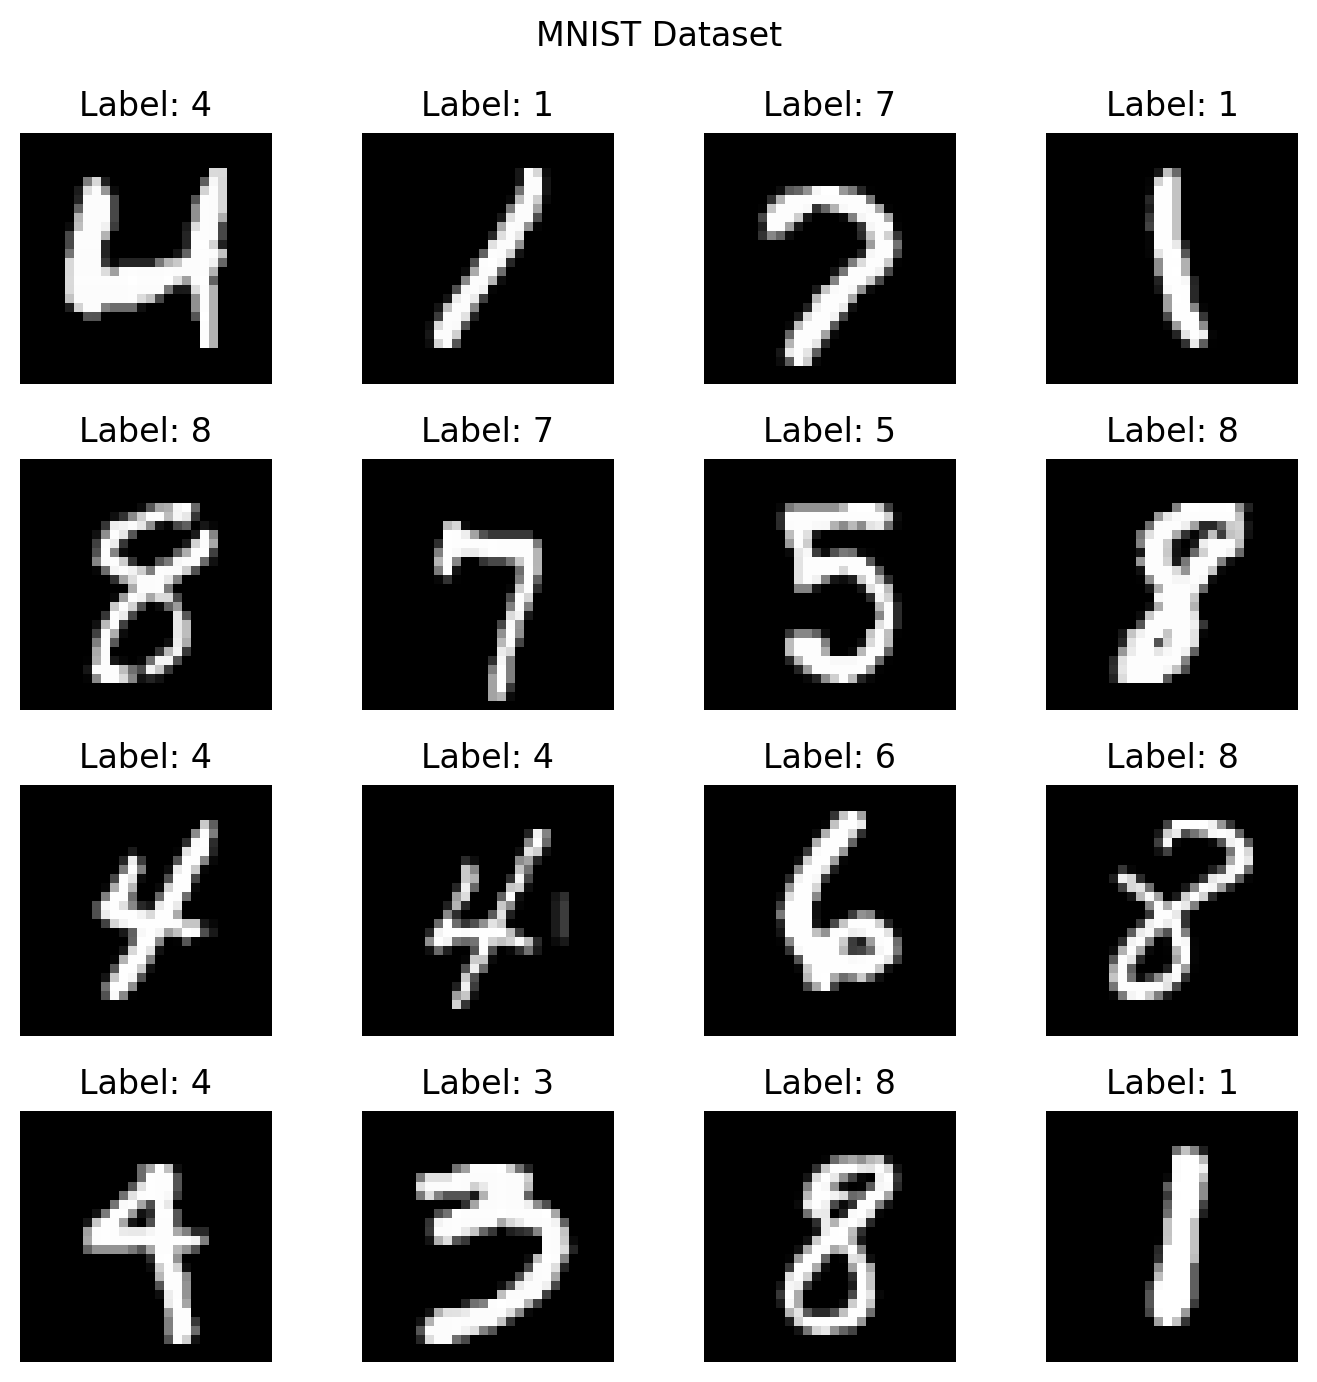

In [9]:
plt.figure(figsize =(7,7))
# 16개의 랜덤한 정수 생성
random_indices = np.random.randint(0, len(x_train), size = 16)

# 16개의 랜덤한 정수에 해당하는 이미지를 4x4 그리드에 하나씩 출력
for n, idx in enumerate(random_indices, start=1):
    # 4x4 그리드의 n번째 위치를 지정
    # 해당 위치에 그레이스케일 이미지를 출력하고, 타이틀로는 라벨 값을 출력
    # x축과 y축이 필요하지 않으므로 눈금 출력 생략
    plt.subplot(4,4,n)
    plt.imshow(x_train[idx].reshape(28,28), cmap='gray')
    plt.title(f"Label: {y_train[idx].argmax()}")
    plt.axis('off')

plt.suptitle('MNIST Dataset')
plt.tight_layout()
plt.show()

In [10]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_prime(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [11]:
class Sigmoid():
    def __init__(self): # class가 인스턴스화될 때 호출되는 생성자
        self.out = None # 이 속성은 순전파에서 시그모이드 함수의 출력을 저장하기 위해 사용됨
    
    def forward(self, x):
        # 순전파가 흐를 시 그 결과물을 attribute로 저장 및 리턴
        self.out = sigmoid(x)
        return self.out

    def backward(self, dout):
        # backpropagation시, 그 gradient 값을 return
        self.out = sigmoid_prime(x)
        return self.out

In [12]:
# 시그모이드 레이어의 순전파/역전파가 잘 작동하는지 테스트
# 임의의 사이즈에 대해 모두 동일한 크기의 결과가 출력되어야 하며, 각각 단순하게 시그모이드 함수를 적용한 값과 도함수를 적용한 값이 된다면 성공

x = np.random.randn(5, 2)
print('x =\n', x)

sigmoid_layer = Sigmoid()
print('\nsigmoid_layer.forward(x) =\n', sigmoid_layer.forward(x))
print('\nsigmoid_layer.backward(1) =\n', sigmoid_layer.backward(1)) # 최종 출력물의 미분값이 1일 경우 역전파의 결과

x =
 [[-0.10321885  0.4105985 ]
 [ 0.14404357  1.45427351]
 [ 0.76103773  0.12167502]
 [ 0.44386323  0.33367433]
 [ 1.49407907 -0.20515826]]

sigmoid_layer.forward(x) =
 [[0.47421817 0.60123138]
 [0.53594876 0.81065526]
 [0.68157899 0.53038128]
 [0.60917918 0.58265313]
 [0.81668973 0.44888958]]

sigmoid_layer.backward(1) =
 [[0.2493353  0.23975221]
 [0.24870769 0.15349331]
 [0.21702907 0.24907698]
 [0.23807991 0.24316846]
 [0.14970761 0.24738772]]


In [13]:
# Fully-Connected Layer 구현하기
class FCLayer():
    def __init__(self, input_size, output_size, weight_init_std=0.01):
        # wight와 bias (정규분포를 따르는 난수로) 초기화
        # randn(m,n) 평균 0, 표준편차 1의 가우시안 표준정규분포 난수 생성
        self.W = np.random.randn(input_size, output_size)
        self.b = np.random.randn(output_size)

        # backpropagation을 위해 입력데이터 저장
        self.x = None
        # 모델 학습을 위해 weight와 Bias의 Gradient 저장
        self.dW = None
        self.db = None

    def forward(self, x):
        # 역전파 계산을 위해 입력 데이터 저장
        self.x = x
        # y = Wx +b
        out = np.dot(x, self.W) + self.b
        return out

    def backward(self, dout):
        # dy/dx = W -> dx = dy + W
        dx = np.dot(dout, self.W.T)
        # dy/dW = x  ->  dW = x * dy
        self.dW = np.dot(self.x.T, dout)
        # dy/db = 1  ->  db = dy * 1
        self.db = np.sum(dout, axis=0)
        return dx


In [14]:
# FCLayer 레이어가 임의의 입출력 데이터에 대해 잘 작동하는지 테스트

x = np.random.randn(5, 2)
y = np.random.randn(5, 3)
print('x =\n', x)

fc_layer = FCLayer(2, 3)
print('\nfc_layer.forward(x) =\n', fc_layer.forward(x))
print('\nfc_layer.backward(y) =\n', fc_layer.backward(y))

x =
 [[ 0.3130677  -0.85409574]
 [-2.55298982  0.6536186 ]
 [ 0.8644362  -0.74216502]
 [ 2.26975462 -1.45436567]
 [ 0.04575852 -0.18718385]]

fc_layer.forward(x) =
 [[ 1.46799167 -1.7190734   1.62817886]
 [-6.01190034  0.91385242  0.45042808]
 [ 2.40336148 -1.9130545   1.20599374]
 [ 6.03706376 -3.18300724  1.73977896]
 [ 0.11102737 -1.06432113  0.66895248]]

fc_layer.backward(y) =
 [[ 2.17336759 -1.02791573]
 [ 2.05790811  2.03279805]
 [-1.29734078 -1.42814094]
 [ 2.67540605 -1.319593  ]
 [-0.57430296  2.96331783]]


In [15]:
# MSE loss function 구현

class MSELoss():
    def __init__(self):
        self.loss = None # 손실함수 값. 역전파 계산을 위해 인스턴스 내에 저장
        self.y = None # 추론 값 y
        self.t = None # 실제값(target)

    def forward(self, y,t):
        self.y = y
        self.t = t
        self.loss = np.mean((t-y)**2)
        return self.loss

    def backward(self, dout = 1):
        dx = dout * (self.y - self.t) *2 / self.t.shape[0]
        return dx

In [16]:
class CrossEntropyLoss():
    '''교차 엔트로피(Cross Entropy) 레이어'''
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, y, t):
        '''교차 엔트로피 레이어의 순방향 전파'''
        # L = -1/N * sum(t * log(y) + (1 - t) * log(1 - y))
        self.y = y
        self.t = t
        self.loss = - np.sum(t * np.log(y + 1e-7) + (1 - t) * np.log(1 - y + 1e-7)) / len(y)
        return self.loss

    def backward(self, dout=1):
        '''교차 엔트로피 레이어의 역방향 전파'''
        # dL/dy = -t/y + (1 - t)/(1 - y)  ->  dy = (-t/y + (1 - t)/(1 - y))
        dx =  dout * (self.y - self.t) / (self.t.shape[0] * (1-self.y) * self.y + 1e-7)
        return dx

In [17]:
class MLP():    # MLP 모델 생성
    def __init__(self, input_size, hidden_size_list, output_size, loss_type='MSE'):
        # 신경망의 구조와 손실 함수 정의
        # input_size: 입력 데이터의 차원 수
        # hidden_size_list: 은닉층 차원 수의 리스트 (e.g. [100, 100, 100])
        # output_size: 출력 데이터의 차원 수
        # loss_type: 손실 함수의 종류 ('MSE' or 'CrossEntropy')
        

        self.input_size = input_size                    # 입력 데이터의 차원수 임시저장
        self.hidden_size_list = hidden_size_list        # 은닉층 차원 수의 리스트 임시저장
        self.output_size = output_size                  # 출력 데이터의 차원수 임시저장
        self.hidden_layer_num = len(hidden_size_list)
        self.loss_type = loss_type

        ### 레이어 쌓기 : FCLayer -> Sigmoid -> ... -> FCLayer -> Sigmoid
        # 입력층
        self.layers = [
            FCLayer(input_size, hidden_size_list[0]),
            Sigmoid()
        ]
        # 은닉층
        for idx in range(1, self.hidden_layer_num):
            self.layers.append(FCLayer(hidden_size_list[idx-1], hidden_size_list[idx]))
            self.layers.append(Sigmoid())
        # 출력층
        self.layers.append(FCLayer(hidden_size_list[-1], output_size))
        self.layers.append(Sigmoid())

        # 인자로 받은 `loss_type`에 맞게 손실 함수 레이어 정하기
        if self.loss_type == 'MSE':
            self.loss_layer = MSELoss()
        elif self.loss_type == 'CrossEntropy':
            self.loss_layer = CrossEntropyLoss()
        else:
            self.loss_layer = None


        self.loss = None

    def predict(self, x):
        '''입력값을 받았을 때 순방향 전파를 통한 출력물 산출(예측)'''
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        '''MLP 모델의 순방향 전파'''
        y = self.predict(x)
        self.loss = self.loss_layer.forward(y, t)
        return self.loss

    def backward(self, dout=1):
        '''MLP 모델의 역방향 전파'''
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

In [18]:
# 임의의 입출력 데이터와 하이퍼파라미터에 대해 MLP 모델이 에러 없이 작동하는지 테스트

x = np.random.randn(5, 2)
y = np.random.randn(5, 1)
print('x =\n', x)

mlp = MLP(input_size=2, hidden_size_list=[10, 5], output_size=1, loss_type='MSE')
print('\nmlp.predict(x) =\n', mlp.predict(x))
print('\nmlp.forward(x, y) =\n', mlp.forward(x, y))
print('\nmlp.backward() =\n', mlp.backward())

x =
 [[-0.51080514 -1.18063218]
 [-0.02818223  0.42833187]
 [ 0.06651722  0.3024719 ]
 [-0.63432209 -0.36274117]
 [-0.67246045 -0.35955316]]

mlp.predict(x) =
 [[0.09179987]
 [0.0957102 ]
 [0.09523428]
 [0.09244939]
 [0.09246448]]

mlp.forward(x, y) =
 1.4714343261962757


ValueError: shapes (5,2) and (1,5) not aligned: 2 (dim 1) != 1 (dim 0)